<a href="https://colab.research.google.com/github/adilsonvj/A-comparative-analysis-of-local-network-similarity-measurement/blob/main/2_Getting_Similarities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tqdm import tqdm

# Plot loss vs iteration and target vs iteration
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
# Callback to stop iterations when reached 99% precision
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get("precision")>0.99):
            print("\n 99% precision reached")
            self.model.stop_training = True

# Weighted version of common neighbors
def weighted_common_neighbors(G, ebunch = None):
    def predict(u,v):
        cnbors = list(nx.common_neighbors(G, u, v))
        return sum(map(lambda x : G[u][x]['weight'] + G[v][x]['weight'], cnbors))
    
    if ebunch is None:
        ebunch = nx.non_edges(G)

    return ((u, v, predict(u, v)) for u, v in ebunch)

# Weighted version of Jaccard Coefficient
def weighted_jaccard_coefficient(G, ebunch = None):
    def predict(u,v):
        cnbors = list(nx.common_neighbors(G, u, v))
        try: return (sum(map(lambda x : G[u][x]['weight'] + G[v][x]['weight'], cnbors)) / (G.degree(u, weight = 'weight') + G.degree(v, weight = 'weight')))
        except: return (0)
    
    if ebunch is None:
        ebunch = nx.non_edges(G)
        
    return ((u, v, predict(u, v)) for u, v in ebunch)

# Weighted version of preferential attachment
def weighted_preferential_attachment(G, ebunch = None):
    def predict(u,v):
        return G.degree(u, weight = 'weight') * G.degree(v, weight = 'weight')
    
    if ebunch is None:
        ebunch = nx.non_edges(G)

    return ((u, v, predict(u, v)) for u, v in ebunch)

# Weighted version of adamic adar
def weighted_adamic_adar(G, ebunch = None):
    def predict(u, v):
        return sum( (G[u][w]['weight'] + G[v][w]['weight']) / math.log(1 + G.degree(w, weight = 'weight'))
              for w in nx.common_neighbors(G, u, v))
    
    if ebunch is None:
        ebunch = nx.non_edges(G)

    return ((u, v, predict(u, v)) for u, v in ebunch)

# Weighted version of resource allocation
def weighted_resource_allocation(G, ebunch=None):
    def predict(u, v):
        return sum( (G[u][w]['weight'] + G[v][w]['weight']) / (1 + G.degree(w, weight = 'weight'))
                  for w in nx.common_neighbors(G, u, v))
    if ebunch is None:
        ebunch = nx.non_edges(G)

    return ((u, v, predict(u, v)) for u, v in ebunch)

# common neighbors
def my_common_neighbors(G, ebunch = None):
    def predict(u, v):
        cnbors = list(nx.common_neighbors(G, u, v))
        return len(cnbors)
    
    if ebunch is None:
        ebunch = nx.non_edges(G)

    return ((u, v, predict(u, v)) for u, v in ebunch)

# Adamic adar with error exception
def my_adamic_adar_index(G, ebunch=None):
    def predict(u, v):
        def not_div_inf(degree):
            try: return 1 / math.log(degree)
            except: return 0
        return sum(not_div_inf(G.degree(w))
                   for w in nx.common_neighbors(G, u, v))
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return ((u, v, predict(u, v)) for u, v in ebunch)

# Function to manage the similarity to return by string
def get_similarity(G, edge_list, link_prediction):
    def get_tuple_sim(x):
        return x[2]
    if link_prediction == "RA":
        link_pred = nx.resource_allocation_index(G, edge_list)
    elif link_prediction == "JC":
        link_pred = nx.jaccard_coefficient(G, edge_list)
    elif link_prediction == "AA":
        link_pred = my_adamic_adar_index(G, edge_list)
    elif link_prediction == "PA":
        link_pred = nx.preferential_attachment(G, edge_list)
    elif link_prediction == "CN":
        link_pred = my_common_neighbors(G, edge_list)
    elif link_prediction == "WRA":
        link_pred = weighted_resource_allocation(G, edge_list)
    elif link_prediction == "WJC":
        link_pred = weighted_jaccard_coefficient(G, edge_list)
    elif link_prediction == "WAA":
        link_pred = weighted_adamic_adar(G, edge_list)
    elif link_prediction == "WPA":
        link_pred = weighted_preferential_attachment(G, edge_list)
    elif link_prediction == "WCN":
        link_pred = weighted_common_neighbors(G, edge_list)
        
    return list(map(get_tuple_sim, link_pred))

In [ ]:
import os

# os.chdir(r'/content/drive/MyDrive/Link Prediction - 1k -  fair')

# Supervised Data

In [ ]:
# Read the training dataset
df_folder = r"dataframes/"
csv_rem_TRAIN_path = os.path.join(df_folder, 'df_TRAIN_1970_2000.pkl')

DF_REM_TRAIN_1970_2000 = pd.read_pickle(csv_rem_TRAIN_path)

In [ ]:
DF_REM_TRAIN_1970_2000

,edges,y
0,"(2311785152, 2194646985)",1
1,"(2143229210, 2527578210)",1
2,"(2112531887, 2056297218)",1
3,"(2131868889, 2139411987)",1
4,"(2024716561, 1911737640)",1
...,...,...
8043,"(2097044971, 2167535989)",0
8044,"(2114432212, 2044280228)",0
8045,"(2434071205, 2168539083)",0
8046,"(1991199846, 2278733449)",0


In [ ]:
DF_REM_TRAIN_1970_2000.head(5)

,edges,y
0,"(2311785152, 2194646985)",1
1,"(2143229210, 2527578210)",1
2,"(2112531887, 2056297218)",1
3,"(2131868889, 2139411987)",1
4,"(2024716561, 1911737640)",1


In [ ]:
# read the training graph
graph_folder = r"graphs"
pkl_path_TRAIN_REM_1970_2000 = os.path.join(graph_folder, 'G_TRAIN_REM_1970_2000.gpickle')

G_TRAIN_REM_1970_2000 = nx.read_gpickle(pkl_path_TRAIN_REM_1970_2000)
G = G_TRAIN_REM_1970_2000.copy()

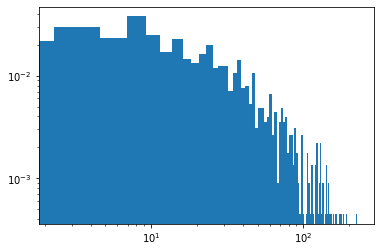

In [ ]:
hist_ = plt.hist(list(dict(G.degree()).values()), density = True, bins = 100)
plt.yscale('log')
plt.xscale('log')

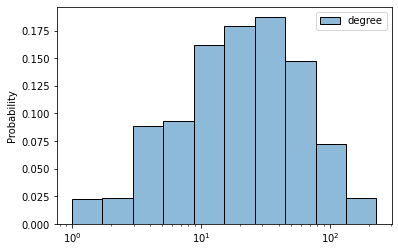

In [ ]:
dg_df = pd.DataFrame(list(dict(G.degree()).values()), columns = ["degree"])
dg_df = dg_df[dg_df["degree"] != 0]
sns.histplot(dg_df, bins = 10, stat = 'probability', log_scale = True)

lognormal 20.749871094911 1.2292054456673648e-95
stretched_exponential 23.671129958070832 7.152990199577254e-124


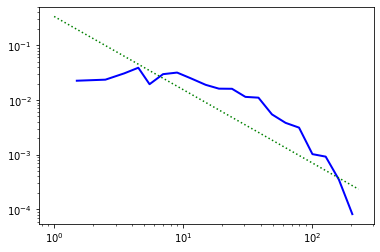

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


G = G_TRAIN_REM_1970_2000

degree_sequence = sorted([d for n, d in G.degree() if d != 0], reverse=True)
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
fit = powerlaw.Fit(degree_sequence, xmin=1)

fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle=':', ax=fig2)

R, p = fit.distribution_compare( 'lognormal', 'power_law', normalized_ratio=True)
print ("lognormal", R, p)

R, p = fit.distribution_compare('stretched_exponential', 'power_law', normalized_ratio=True)
print ("stretched_exponential", R, p)

# Plotting the degree distribution against the power law fitted distribution

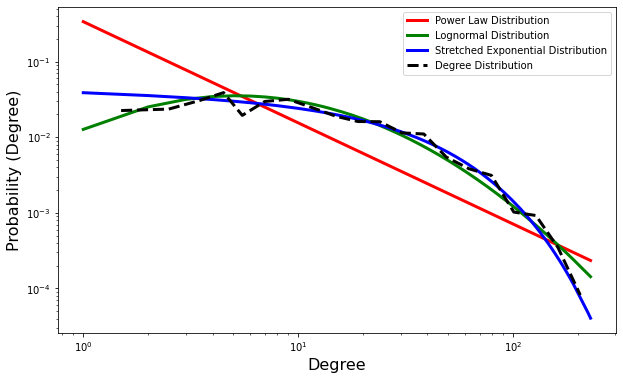

In [ ]:
# Plotting the degree distribution against the power law fitted distribution,
# lognormal and stretched exponential

plt.figure(figsize=(10, 6))

fig4 = fit.power_law.plot_pdf(linewidth=3, color='r', linestyle='-', label = "Power Law Distribution") #powerlaw
fit.lognormal.plot_pdf(linewidth=3, ax=fig4, color='g', linestyle='-', label = "Lognormal Distribution") #lognormal
fit.stretched_exponential.plot_pdf(linewidth=3, ax=fig4, color='b', linestyle='-', label = "Stretched Exponential Distribution") #stretched_exponential
fit.plot_pdf(ax=fig4, linewidth=3, linestyle='--', color='black', label = "Degree Distribution")

plt.ylabel("Probability (Degree)", fontsize = 16)
plt.xlabel("Degree", fontsize = 16)
plt.legend()
plt.show()

In [ ]:
edges_TRAIN_1970_2000 = DF_REM_TRAIN_1970_2000.edges.tolist()

In [ ]:
# Get each of the 10 metrics (5 normal and 5 weighted)
measure_list = ["PA", "WPA", "CN", "WCN", "AA", "WAA", "RA", "WRA", "JC", "WJC"]
for measure_ in tqdm(measure_list):
    DF_REM_TRAIN_1970_2000[measure_] = get_similarity(G_TRAIN_REM_1970_2000
                                            , edges_TRAIN_1970_2000, measure_)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [ ]:
DF_REM_TRAIN_1970_2000.head()

,edges,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC
0,"(2311785152, 2194646985)",1,8694,844336,28,918,6.737452,144.060371,0.475135,2.002833,0.161850,0.395690
1,"(2143229210, 2527578210)",1,4576,153264,27,593,5.906393,86.323692,0.310432,0.798584,0.238938,0.736646
2,"(2112531887, 2056297218)",1,2201,83345,11,174,2.810895,28.640419,0.253370,0.618103,0.120879,0.153439
3,"(2131868889, 2139411987)",1,2002,13425,3,40,0.644589,5.719506,0.030845,0.039203,0.015789,0.043956
4,"(2024716561, 1911737640)",1,390,9472,1,205,0.253085,33.629577,0.019231,0.461712,0.025000,0.699659


In [ ]:
# save training measures
path_rem_train_1970_2000 = os.path.join(df_folder, "df_TRAIN_1970_2000_MEASURES.pkl")
DF_REM_TRAIN_1970_2000.to_pickle(path_rem_train_1970_2000)

# Unsupervised Data

In [ ]:
# read training graph
pkl_path_TRAIN_FULL_1970_2000 = os.path.join(graph_folder, 'G_TRAIN_FULL_1970_2000.gpickle')
G_TRAIN_FULL_1970_2000 = nx.read_gpickle(pkl_path_TRAIN_FULL_1970_2000)

In [ ]:
# read test dataset
df_test_2000_2016_path = os.path.join(df_folder, "df_TEST_2000_2016.pkl")
DF_TEST_2000_2016 = pd.read_pickle(df_test_2000_2016_path)

In [ ]:
DF_TEST_2000_2016

,edges,year,y
0,"(2143146826, 2564007945)",2001,1
1,"(2279601013, 2026855265)",2001,1
2,"(2164815468, 2104799500)",2001,1
3,"(2077484404, 2469167886)",2001,1
4,"(2235923408, 2064625021)",2001,1
...,...,...,...
157133,"(2472878894, 2422950260)",9999,0
157134,"(2070953463, 2478624925)",9999,0
157135,"(2048746224, 2153856636)",9999,0
157136,"(2423670809, 38343657)",9999,0


In [ ]:
edges_TEST_2000_2016 = DF_TEST_2000_2016.edges.tolist()

In [ ]:
# get similarity metrics for test dataset
measure_list = ["PA", "WPA", "CN", "WCN", "AA", "WAA", "RA", "WRA", "JC", "WJC"]
for measure_ in tqdm(measure_list):
    DF_TEST_2000_2016[measure_] = get_similarity(G_TRAIN_FULL_1970_2000
                                            , edges_TEST_2000_2016, measure_)

100%|██████████| 10/10 [19:48<00:00, 118.86s/it]


In [ ]:
ids_0_year = DF_TEST_2000_2016.query("year == 0").index.tolist()
DF_TEST_2000_2016.loc[ids_0_year, "year"] = 9999

In [ ]:
DF_TEST_2000_2016.head()

,edges,year,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC
0,"(2143146826, 2564007945)",2001,1,450,9815,2,27,0.397582,3.607638,0.013072,0.015173,0.037736,0.125000
1,"(2279601013, 2026855265)",2001,1,1617,9360,12,52,2.527674,7.905581,0.109612,0.085980,0.171429,0.263959
2,"(2164815468, 2104799500)",2001,1,2044,19292,3,12,0.554536,1.612136,0.013513,0.007125,0.030612,0.039604
3,"(2077484404, 2469167886)",2001,1,2550,29808,21,207,4.521172,31.544239,0.219645,0.357763,0.262500,0.589744
4,"(2235923408, 2064625021)",2001,1,95,505,3,7,0.671738,1.068488,0.036804,0.014509,0.142857,0.066038


In [ ]:
DF_TEST_2000_2016.tail()

,edges,year,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC
157133,"(2472878894, 2422950260)",9999,0,594,14241,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
157134,"(2070953463, 2478624925)",9999,0,798,22792,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
157135,"(2048746224, 2153856636)",9999,0,322,1456,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
157136,"(2423670809, 38343657)",9999,0,104,290,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
157137,"(2317898032, 2420026243)",9999,0,1161,10720,5,34,1.057348,5.446025,0.046802,0.073885,0.076923,0.158879


In [ ]:
path_full_test_1970_2000 = os.path.join(df_folder, "df_TEST_2000_2016_MEASURES_999.pkl")
DF_TEST_2000_2016.to_pickle(path_full_test_1970_2000)

# Test

In [ ]:
test_df = DF_TEST_2000_2016.copy()

measure_list = ["PA", "WPA", "CN", "WCN", "AA", "WAA", "RA", "WRA", "JC", "WJC"]

test_df = test_df.query("year != 9999").reset_index(drop = True)
for measure_ in measure_list:
    test_df[measure_] = (test_df[measure_] - test_df[measure_].min()) / (test_df[measure_].max() - test_df[measure_].min())

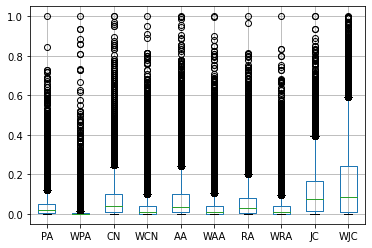

In [ ]:
test_df.boxplot(column = measure_list)

# Deep Learning

In [ ]:
df_folder = r"dataframes/"
pkl_rem_TRAIN_path = os.path.join(df_folder, "df_TRAIN_1970_2000_MEASURES.pkl")
DF_REM_TRAIN_1970_2000 = pd.read_pickle(pkl_rem_TRAIN_path)

In [ ]:
DF_REM_TRAIN_1970_2000

,edges,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC
0,"(2311785152, 2194646985)",1,8694,844336,28,918,6.737452,144.060371,0.475135,2.002833,0.161850,0.395690
1,"(2143229210, 2527578210)",1,4576,153264,27,593,5.906393,86.323692,0.310432,0.798584,0.238938,0.736646
2,"(2112531887, 2056297218)",1,2201,83345,11,174,2.810895,28.640419,0.253370,0.618103,0.120879,0.153439
3,"(2131868889, 2139411987)",1,2002,13425,3,40,0.644589,5.719506,0.030845,0.039203,0.015789,0.043956
4,"(2024716561, 1911737640)",1,390,9472,1,205,0.253085,33.629577,0.019231,0.461712,0.025000,0.699659
...,...,...,...,...,...,...,...,...,...,...,...,...
8043,"(2097044971, 2167535989)",0,609,4896,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8044,"(2114432212, 2044280228)",0,510,4384,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8045,"(2434071205, 2168539083)",0,111,693,1,5,0.233827,0.810975,0.013889,0.010504,0.025641,0.047170
8046,"(1991199846, 2278733449)",0,3930,49049,12,95,2.612769,14.281530,0.127863,0.161527,0.080537,0.133053


In [ ]:
X = DF_REM_TRAIN_1970_2000.drop(["edges", "y"], axis = 1)
y = DF_REM_TRAIN_1970_2000[["y"]]

In [ ]:
X

,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC
0,8694,844336,28,918,6.737452,144.060371,0.475135,2.002833,0.161850,0.395690
1,4576,153264,27,593,5.906393,86.323692,0.310432,0.798584,0.238938,0.736646
2,2201,83345,11,174,2.810895,28.640419,0.253370,0.618103,0.120879,0.153439
3,2002,13425,3,40,0.644589,5.719506,0.030845,0.039203,0.015789,0.043956
4,390,9472,1,205,0.253085,33.629577,0.019231,0.461712,0.025000,0.699659
...,...,...,...,...,...,...,...,...,...,...
8043,609,4896,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8044,510,4384,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8045,111,693,1,5,0.233827,0.810975,0.013889,0.010504,0.025641,0.047170
8046,3930,49049,12,95,2.612769,14.281530,0.127863,0.161527,0.080537,0.133053


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
std_scaler = StandardScaler().fit(X_train)

X_train_sc = std_scaler.transform(X_train)
X_test_sc = std_scaler.transform(X_test)

In [ ]:
X_2000_2016 = DF_TEST_2000_2016.drop(["edges", "year", "y"], axis = 1)
y_2000_2016 = DF_TEST_2000_2016[["y"]]

X_2000_2016_scl = std_scaler.transform(X_2000_2016)

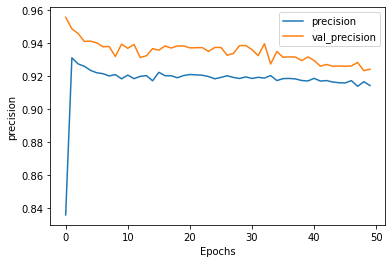

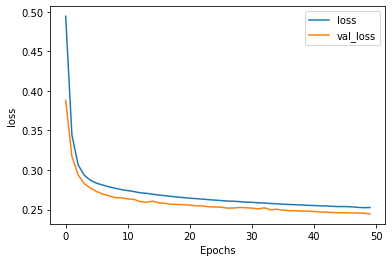

51/51 [==============================] - 0s 2ms/step - loss: 0.2444 - auc: 0.9655 - precision: 0.9242
precision train 0.965 precision test 0.924


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 16, activation = 'sigmoid'),
#     tf.keras.layers.Dense(units = 64, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ["AUC", tf.keras.metrics.Precision(name = 'precision')]
)

history = model.fit(
    X_train_sc,
    y_train,
    batch_size = 32,
    epochs = 50,
    validation_data = (X_test_sc, y_test),
    callbacks = [CustomCallbacks()],
)

clear_output()

plot_graphs(history, 'precision')
plot_graphs(history, 'loss')

_, prec_train, prec_test = model.evaluate(X_test_sc, y_test)
print("precision train %.3f"%prec_train, "precision test %.3f"%prec_test)

In [ ]:
DF_TEST_2000_2016["ANN"] = model.predict(X_2000_2016_scl)

In [ ]:
DF_TEST_2000_2016.head(5)

,edges,year,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC,ANN
0,"(2143146826, 2564007945)",2001,1,450,9815,2,27,0.397582,3.607638,0.013072,0.015173,0.037736,0.125000,0.182378
1,"(2279601013, 2026855265)",2001,1,1617,9360,12,52,2.527674,7.905581,0.109612,0.085980,0.171429,0.263959,0.679498
2,"(2164815468, 2104799500)",2001,1,2044,19292,3,12,0.554536,1.612136,0.013513,0.007125,0.030612,0.039604,0.102159
3,"(2077484404, 2469167886)",2001,1,2550,29808,21,207,4.521172,31.544239,0.219645,0.357763,0.262500,0.589744,0.964608
4,"(2235923408, 2064625021)",2001,1,95,505,3,7,0.671738,1.068488,0.036804,0.014509,0.142857,0.066038,0.241534


# Logistic Regression

In [ ]:
grid={"C":np.logspace(-5, 5, 20), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv = 5, n_jobs = -1, scoring = ["precision", "roc_auc"]
                         , refit = "precision")
logreg_cv.fit(X_train_sc, y_train)

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("train accuracy :", logreg_cv.best_score_)
print("test accuracy :", logreg_cv.score(X_test_sc, y_test))

tuned hpyerparameters :(best parameters)  {'C': 1e-05, 'penalty': 'l2'}
train accuracy : 0.9524797491295086
test accuracy : 0.9616724738675958


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

In [ ]:
DF_TEST_2000_2016["LR"] = logreg_cv.predict_proba(X_2000_2016_scl)[:, 1]

In [ ]:
DF_TEST_2000_2016.head(5)

,edges,year,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC,ANN,LR
0,"(2143146826, 2564007945)",2001,1,450,9815,2,27,0.397582,3.607638,0.013072,0.015173,0.037736,0.125000,0.182378,0.477284
1,"(2279601013, 2026855265)",2001,1,1617,9360,12,52,2.527674,7.905581,0.109612,0.085980,0.171429,0.263959,0.679498,0.497381
2,"(2164815468, 2104799500)",2001,1,2044,19292,3,12,0.554536,1.612136,0.013513,0.007125,0.030612,0.039604,0.102159,0.476176
3,"(2077484404, 2469167886)",2001,1,2550,29808,21,207,4.521172,31.544239,0.219645,0.357763,0.262500,0.589744,0.964608,0.523929
4,"(2235923408, 2064625021)",2001,1,95,505,3,7,0.671738,1.068488,0.036804,0.014509,0.142857,0.066038,0.241534,0.481596


# SVC

In [ ]:
grid = {'C':[0.1, 1,10,100,1000]
        ,'gamma':[1,0.1,0.001,0.0001, 0.00001, 0.000001]
        , 'kernel':['linear','rbf']}
svc_model = SVC(probability=True)
svc_model = GridSearchCV(svc_model, grid, cv = 5, n_jobs = -1, verbose = 1
                                , scoring = ["precision", "roc_auc"], refit = "precision")
svc_model.fit(X_train_sc, y_train)

print("tuned hpyerparameters :(best parameters) ", svc_model.best_params_)
print("train accuracy :", svc_model.best_score_)
print("test accuracy :", svc_model.score(X_test_sc, y_test))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tuned hpyerparameters :(best parameters)  {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
train accuracy : 0.9929650188521156
test accuracy : 0.9801980198019802


In [ ]:
DF_TEST_2000_2016["SVC"] = svc_model.predict_proba(X_2000_2016_scl)[:, 1]

In [ ]:
DF_TEST_2000_2016.head(5)

,edges,year,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC,ANN,LR,SVC
0,"(2143146826, 2564007945)",2001,1,450,9815,2,27,0.397582,3.607638,0.013072,0.015173,0.037736,0.125000,0.182378,0.477284,0.226772
1,"(2279601013, 2026855265)",2001,1,1617,9360,12,52,2.527674,7.905581,0.109612,0.085980,0.171429,0.263959,0.679498,0.497381,0.895412
2,"(2164815468, 2104799500)",2001,1,2044,19292,3,12,0.554536,1.612136,0.013513,0.007125,0.030612,0.039604,0.102159,0.476176,0.191999
3,"(2077484404, 2469167886)",2001,1,2550,29808,21,207,4.521172,31.544239,0.219645,0.357763,0.262500,0.589744,0.964608,0.523929,0.999994
4,"(2235923408, 2064625021)",2001,1,95,505,3,7,0.671738,1.068488,0.036804,0.014509,0.142857,0.066038,0.241534,0.481596,0.382247


# XGBoost

In [ ]:

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

xgboostC_model = XGBClassifier(objective="binary:logistic")
xgboostC_model = GridSearchCV(xgboostC_model, param_grid, cv = 5
                , n_jobs = -1, verbose = 2, refit = "precision", scoring = ["precision", "roc_auc"])
xgboostC_model.fit(X_train_sc, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'gamma': [0, 0.25, 1],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 7], 'reg_lambda': [0, 1, 10],
                         'scale_pos_weight': [1, 3, 5], 'subsample': [0.8]},
             refit='precision', scoring=['precision', 'roc_auc'], verbose=2)

In [ ]:
print("tuned hpyerparameters :(best parameters) ", xgboostC_model.best_params_)
print("train accuracy :",xgboostC_model.best_score_)
print("test accuracy :",xgboostC_model.score(X_test_sc, y_test))

tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.8}
train accuracy : 0.8994824114882742
test accuracy : 0.9019138755980861


In [ ]:
DF_TEST_2000_2016["XGBOOST"] = xgboostC_model.predict_proba(X_2000_2016_scl)[:, 1]

In [ ]:
DF_TEST_2000_2016.head(5)

,edges,year,y,PA,WPA,CN,WCN,AA,WAA,RA,WRA,JC,WJC,ANN,LR,SVC,XGBOOST
0,"(2143146826, 2564007945)",2001,1,450,9815,2,27,0.397582,3.607638,0.013072,0.015173,0.037736,0.125000,0.182378,0.477284,0.226772,0.112445
1,"(2279601013, 2026855265)",2001,1,1617,9360,12,52,2.527674,7.905581,0.109612,0.085980,0.171429,0.263959,0.679498,0.497381,0.895412,0.635889
2,"(2164815468, 2104799500)",2001,1,2044,19292,3,12,0.554536,1.612136,0.013513,0.007125,0.030612,0.039604,0.102159,0.476176,0.191999,0.042789
3,"(2077484404, 2469167886)",2001,1,2550,29808,21,207,4.521172,31.544239,0.219645,0.357763,0.262500,0.589744,0.964608,0.523929,0.999994,0.960202
4,"(2235923408, 2064625021)",2001,1,95,505,3,7,0.671738,1.068488,0.036804,0.014509,0.142857,0.066038,0.241534,0.481596,0.382247,0.316618


In [ ]:
DF_TEST_2000_2016.to_pickle("dataframes/df_TEST_2000_2016_ALL_MEASURES.pkl")